In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/fetch-coding-round

/content/drive/MyDrive/Colab Notebooks/fetch-coding-round


### Tried seq2seq, Arima and Exponential MA, Arima performs the best

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
df = pd.read_csv("data_daily.csv")

df["# Date"] = pd.to_datetime(df["# Date"])
df["Receipt_Count"] /= 1000000
df["woy"] = df["# Date"].dt.isocalendar().week.astype(int) / 10
df["month"] = df["# Date"].dt.month.astype(int)
df.set_index("# Date", inplace=True)

df.head()

,Receipt_Count,woy,month
# Date,,,
2021-01-01,7.564766,5.3,1
2021-01-02,7.455524,5.3,1
2021-01-03,7.095414,5.3,1
2021-01-04,7.666163,0.1,1
2021-01-05,7.771289,0.1,1


In [ ]:
df.describe()

,Receipt_Count,woy,month
count,365.000000,365.000000,365.000000
mean,8.826566,2.657808,6.526027
std,0.782009,1.508174,3.452584
min,7.095414,0.100000,1.000000
25%,8.142874,1.400000,4.000000
50%,8.799249,2.700000,7.000000
75%,9.476970,4.000000,10.000000
max,10.738865,5.300000,12.000000


In [ ]:
df.corr()

,Receipt_Count,woy,month
Receipt_Count,1.000000,0.906329,0.957785
woy,0.906329,1.000000,0.949729
month,0.957785,0.949729,1.000000


In [ ]:
x1 = []
for window in df[:-7].rolling(7):
    x1.append(window.values)

x1 = np.array(x1[6:])
x1.shape

(352, 7, 3)

In [ ]:
x2, y = [], []

for window in df["Receipt_Count"][7:].rolling(7):
    y.append(window)
    x2.append(window.tolist())

y = np.array(y[6:])
x2 = np.array(list(map(lambda e: [0] + e[:-1], x2[6:])))
x2 = x2.reshape((-1, 7, 1))
x2.shape, y.shape

((352, 7, 1), (352, 7))

### seq2seq

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(None, 3))
encoder_dense = tf.keras.layers.Dense(16)
encoder = tf.keras.layers.GRU(32, return_state=True)
encoder_outputs, state_h = encoder(encoder_dense(encoder_inputs))

decoder_inputs = tf.keras.layers.Input(shape=(None, 1))
decoder_gru = tf.keras.layers.GRU(32, return_sequences=True, return_state=True)
decoder_outputs, h = decoder_gru(decoder_inputs, initial_state=state_h)
dense16 = tf.keras.layers.Dense(16)
decoder_dense = tf.keras.layers.Dense(1)
decoder_outputs = decoder_dense(dense16(decoder_outputs))
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer="sgd", loss="mae")

In [ ]:
model.fit([x1, x2], y, batch_size=1, epochs=20)

Epoch 1/20
352/352 [==============================] - 3s 4ms/step - loss: 0.7675
Epoch 2/20
352/352 [==============================] - 2s 6ms/step - loss: 0.4212
Epoch 3/20
352/352 [==============================] - 2s 6ms/step - loss: 0.3649
Epoch 4/20
352/352 [==============================] - 2s 7ms/step - loss: 0.3619
Epoch 5/20
352/352 [==============================] - 2s 5ms/step - loss: 0.3352
Epoch 6/20
352/352 [==============================] - 2s 5ms/step - loss: 0.3269
Epoch 7/20
352/352 [==============================] - 2s 5ms/step - loss: 0.3146
Epoch 8/20
352/352 [==============================] - 2s 5ms/step - loss: 0.3202
Epoch 9/20
352/352 [==============================] - 1s 3ms/step - loss: 0.2989
Epoch 10/20
352/352 [==============================] - 1s 3ms/step - loss: 0.3004
Epoch 11/20
352/352 [==============================] - 1s 4ms/step - loss: 0.2882
Epoch 12/20
352/352 [==============================] - 1s 4ms/step - loss: 0.2960
Epoch 13/20
352/352 [====

In [ ]:
encoder_model = tf.keras.models.Model(encoder_inputs, state_h)

decoder_state_input_h = tf.keras.layers.Input(shape=(32,))
decoder_outputs, h = decoder_gru(decoder_inputs, initial_state=decoder_state_input_h)
decoder_outputs = decoder_dense(dense16(decoder_outputs))
decoder_model = tf.keras.models.Model(
    [decoder_inputs] + [decoder_state_input_h],
    [decoder_outputs] + [h]
)

In [ ]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    decoder_inp = np.zeros((1, 1, 1))
    stop_condition = False
    decoded_sequence = []
    while len(decoded_sequence) != 7:
        output_tokens, h = decoder_model.predict(
            [decoder_inp] + [states_value], verbose=0)

        decoded_sequence.append(output_tokens[-1][-1][-1])
        # Update the target sequence (of length 1).
        decoder_inp = np.array(decoded_sequence).reshape((1, len(decoded_sequence), 1))

        # Update states
        states_value = [h]

    return decoded_sequence


In [ ]:
out = pd.DataFrame(pd.date_range("2022-01-01", "2023-01-06"), columns=["# Date"])
out["woy"] = out["# Date"].dt.isocalendar().week.astype(int)
out["month"] = out["# Date"].dt.month.astype(int)
out["Receipt_Count"] = 0
date = out.pop("# Date")
out.head()

,woy,month,Receipt_Count
0,52,1,0
1,52,1,0
2,1,1,0
3,1,1,0
4,1,1,0


In [ ]:
preds = df[-7:].values
for i in range(0, out.shape[0], 7):
    preds = decode_sequence(tf.expand_dims(preds, 0))
    out["Receipt_Count"][i: i + 7] = preds
    preds = out[i: i + 7].values

out["# Date"] = date
out.set_index("# Date", inplace=True)

In [ ]:
out.head()

,woy,month,Receipt_Count
# Date,,,
2022-01-01,52,1,9.861155
2022-01-02,52,1,9.795651
2022-01-03,1,1,9.759672
2022-01-04,1,1,9.718727
2022-01-05,1,1,9.609900


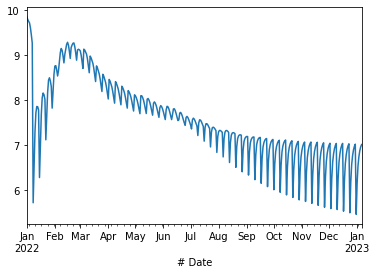

In [ ]:
out["Receipt_Count"].plot()

### ARIMA

In [ ]:
import pickle
import pmdarima as pm

model = pm.auto_arima(df["Receipt_Count"], seasonal=True, m=7)
with open('arima.pkl', 'wb') as f:
    # A new file will be created
    pickle.dump(model, f)
next_year = model.predict(365)

In [ ]:
out = pd.DataFrame(pd.date_range("2022-01-01", "2022-12-31"), columns=["# Date"])
out["woy"] = out["# Date"].dt.isocalendar().week.astype(int)
out["month"] = out["# Date"].dt.month.astype(int)
out.set_index("# Date", inplace=True)
out["Receipt_Count"] = next_year.values

In [ ]:
out.head()

,woy,month,Receipt_Count
# Date,,,
2022-01-01,52,1,10.104191
2022-01-02,52,1,10.109243
2022-01-03,1,1,10.135640
2022-01-04,1,1,10.161634
2022-01-05,1,1,10.172404


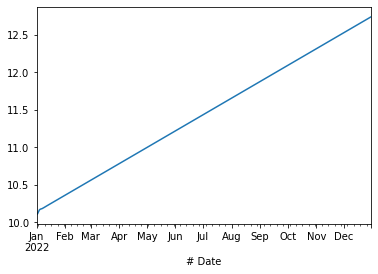

In [ ]:
out["Receipt_Count"].plot()

Exponential MA

<ipython-input-21-1c5645a8806c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out["Receipt_Count"][i: i + 3] = preds


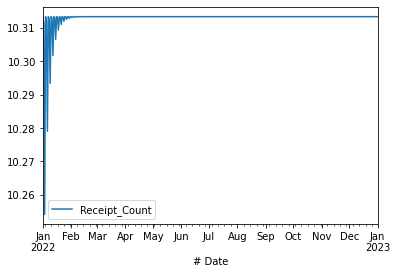

In [ ]:
out = df['Receipt_Count'].to_frame()
 
# calculating exponential moving average
# using .ewm(span).mean() , with window size = 7
out['EWMA7'] = df['Receipt_Count'].ewm(span=7).mean()
out['EWMA3'] = df['Receipt_Count'].ewm(span=3).mean()

out = pd.DataFrame(pd.date_range("2022-01-01", "2023-01-01"), columns=["# Date"])
out["Receipt_Count"] = 0

preds = df['Receipt_Count'][-3:]
for i in range(0, 366, 3):
    preds = preds.ewm(span=3).mean()
    out["Receipt_Count"][i: i + 3] = preds

out["# Date"] = date
out.set_index("# Date", inplace=True)
out.plot()